In [2]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.4 MB/s eta 0:00:00


Using device: cuda
Generation 0/1000, Best MSE: 4.25418711
Generation 100/1000, Best MSE: 3.77419281
Generation 200/1000, Best MSE: 3.23719883
Generation 300/1000, Best MSE: 2.82774305
Generation 400/1000, Best MSE: 2.51426506
Generation 500/1000, Best MSE: 2.20767689
Generation 600/1000, Best MSE: 1.96268153
Generation 700/1000, Best MSE: 1.76872277
Generation 800/1000, Best MSE: 1.54540837
Generation 900/1000, Best MSE: 1.37717748
Generation 999/1000, Best MSE: 1.25705838
GD Step 0/500, MSE Loss: 1.25705838
GD Step 100/500, MSE Loss: 0.07288042
GD Step 200/500, MSE Loss: 0.06132939
GD Step 300/500, MSE Loss: 0.06118025
GD Step 400/500, MSE Loss: 0.06117946
GD Step 499/500, MSE Loss: 0.06117946


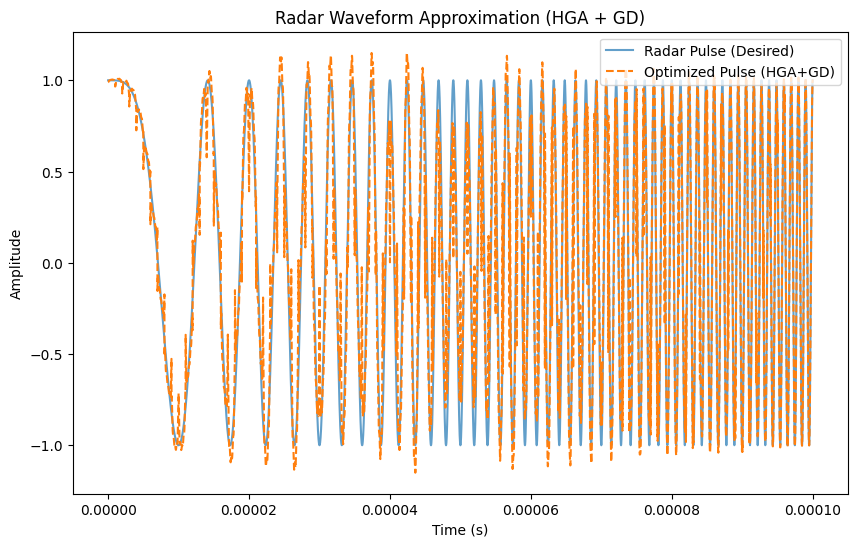

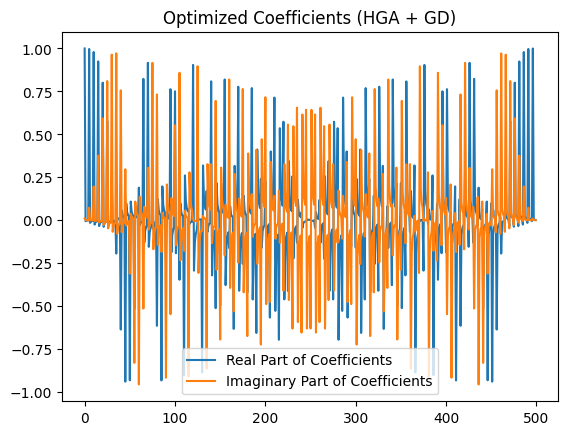

In [3]:
import numpy as np
import torch
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
import matplotlib.pyplot as plt

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Time vector
t = torch.linspace(0, 1e-4, int(1e4), device=device)

# Generate Walsh matrix for CDMA
def generate_walsh_matrix(order):
    def hadamard_matrix(order):
        if order == 1:
            return np.array([[1]])
        else:
            h = hadamard_matrix(order // 2)
            return np.block([[h, h], [h, -h]])
    order = 2 ** int(np.ceil(np.log2(order)))
    walsh_matrix = hadamard_matrix(order)
    walsh_matrix[walsh_matrix == +1] = 0
    walsh_matrix[walsh_matrix == -1] = 1
    return walsh_matrix

# Base class for pulse generators
class BasePulseGenerator:
    def __init__(self, t, Tb=None, T=None, device='cpu'):
        self.device = device
        self.t = self._to_tensor(t)
        self.Tb = Tb
        self.T = T

    def _to_tensor(self, t):
        if isinstance(t, np.ndarray):
            t = torch.from_numpy(t).to(self.device)
        return t

# Communication pulse generator
class CommPulseGenerator(BasePulseGenerator):
    def OFDMA_pulse(self, l, k):
        return (torch.exp(1j * 2 * torch.pi * k / self.Tb * (self.t - l * self.Tb)) *
                (torch.heaviside(self.t - l * self.Tb, torch.tensor([1.0], device=self.device)) -
                 torch.heaviside(self.t - (l + 1) * self.Tb, torch.tensor([0.0], device=self.device))))

# Radar pulse generator
class RadarPulseGenerator(BasePulseGenerator):
    def LFM_pulse(self, B):
        return torch.exp(1j * torch.pi * B / self.T * (self.t ** 2))

# Parameters
T = 1e-4       # Total duration of radar pulse
B = 1e6        # Bandwidth of radar pulse
K = 5          # Number of OFDMA users
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval

# Pulse generators
myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)

# Desired radar pulse
radar_pulse = myRadarPulses.LFM_pulse(B)
radar_power = torch.sum(torch.abs(radar_pulse)**2) * (t[1] - t[0])

# Generate communication pulse combinations
g_vec = torch.zeros((L * K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l * K + k, :] = myCommPulses.OFDMA_pulse(l, k)

# Fitness function
def fitness_fn(individual):
    N = len(individual) // 2
    real_val = torch.tensor(individual[:N], device=device, dtype=torch.float32)
    imag_val = torch.tensor(individual[N:], device=device, dtype=torch.float32)
    c_opt = real_val + 1j * imag_val
    s_opt = torch.sum(c_opt[:, None] * g_vec, dim=0)
    mse = torch.mean(torch.abs(s_opt - radar_pulse) ** 2).item()
    return mse,

# DEAP setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, L * K * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness_fn)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Adaptive mutation and crossover rates
def adaptive_mutation_rate(gen, max_gen, initial_rate=0.2, final_rate=0.01):
    return initial_rate + (final_rate - initial_rate) * (gen / max_gen)

def adaptive_crossover_rate(gen, max_gen, initial_rate=0.7, final_rate=0.9):
    return initial_rate + (final_rate - initial_rate) * (1 - gen / max_gen)

# HGA execution
n_generations = 1000
population = toolbox.population(n=50)
elitism_count = 2

for gen in range(n_generations):
    toolbox.mutpb = adaptive_mutation_rate(gen, n_generations)
    toolbox.cxpb = adaptive_crossover_rate(gen, n_generations)

    offspring = algorithms.varAnd(population, toolbox, cxpb=toolbox.cxpb, mutpb=toolbox.mutpb)
    for ind in offspring:
        ind.fitness.values = toolbox.evaluate(ind)

    elites = tools.selBest(population, elitism_count)
    population[:] = tools.selBest(offspring + elites, len(population))

    if gen % 100 == 0 or gen == n_generations - 1:
        best_ind = tools.selBest(population, k=1)[0]
        print(f"Generation {gen}/{n_generations}, Best MSE: {best_ind.fitness.values[0]:.8f}")

# Best individual after HGA
best_individual = tools.selBest(population, k=1)[0]

# Gradient Descent fine-tuning
from torch.optim import Adam

N = len(best_individual) // 2
best_coeffs = torch.tensor(best_individual, device=device, requires_grad=True, dtype=torch.float32)
optimizer = Adam([best_coeffs], lr=0.01)

for step in range(500):
    optimizer.zero_grad()
    real_val = best_coeffs[:N]
    imag_val = best_coeffs[N:]
    c_opt = real_val + 1j * imag_val
    s_opt = torch.sum(c_opt[:, None] * g_vec, dim=0)
    mse_loss = torch.mean(torch.abs(s_opt - radar_pulse) ** 2)
    mse_loss.backward()
    optimizer.step()

    if step % 100 == 0 or step == 499:
        print(f"GD Step {step}/500, MSE Loss: {mse_loss.item():.8f}")

# Final coefficients and synthesized signal
final_coeffs = best_coeffs.detach().cpu().numpy()
real_final = final_coeffs[:N]
imag_final = final_coeffs[N:]
c_opt_final = torch.tensor(real_final, device=device) + 1j * torch.tensor(imag_final, device=device)
s_opt_final = torch.sum(c_opt_final[:, None] * g_vec, dim=0)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t.cpu(), radar_pulse.cpu().real, label="Radar Pulse (Desired)", alpha=0.7)
plt.plot(t.cpu(), s_opt_final.cpu().real, label="Optimized Pulse (HGA+GD)", linestyle="--")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Radar Waveform Approximation (HGA + GD)")
plt.show()

plt.figure()
plt.plot(real_final, label="Real Part of Coefficients")
plt.plot(imag_final, label="Imaginary Part of Coefficients")
plt.legend()
plt.title("Optimized Coefficients (HGA + GD)")
plt.show()
